Notes:

* implement policy gradient method
* train step after episode
* training in script outside of colab (w/o rendering to save)
* use same arch: https://github.com/mswang12/Blog/blob/master/Completed_2020/REINFORCE_reimplementation/REINFORCE_reimplementation.py
* distributions: https://pytorch.org/docs/stable/distributions.html
* toy example: https://github.com/Finspire13/pytorch-policy-gradient-example/blob/master/pg.py
* https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

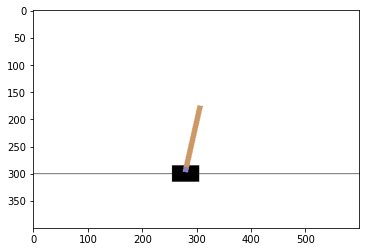

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(1000):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')  # Skip if want to train w/o image

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

In [ ]:
print(obs, reward, action)

[-0.15659019 -0.76654657  0.22219179  1.50925089] 1.0 0


In [ ]:
import torch
from torch import nn
# import torch.distributions 

class Agent(nn.Module):
    def __init__(self, state_shape, action_shape):
        super(Agent, self).__init__()
        self.state_shape = state_shape
        self.action_shape = action_shape

        self.relu = nn.ReLU(inplace=True)
        self.linear1 = nn.Linear(state_shape, 24)
        self.linear2 = nn.Linear(24, 12)
        self.linear3 = nn.Linear(12, action_shape)
        self.softmax = nn.Softmax()

    def forward(self, state):
        # print(state, state.shape)
        x = self.relu(self.linear1(state))
        x = self.relu(self.linear2(x))
        action = self.softmax(self.linear3(x))
        # action = self.linear3(x)
        
        return action

def one_hot_encode_action(action, n_actions):
    encoded = np.zeros(n_actions, np.float32)
    encoded[action] = 1
    return encoded

def get_discounted_rewards(rewards):
    """
    - The discounted rewards sum up all the rewards in the episode
    - Later rewards are exponentially less important
    """
    discounted_rewards = np.zeros((len(rewards), 1))
    running_add = 0
    gamma = 0.99
    for t in reversed(range(0, len(rewards))):
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

# loss = nn.CrossEntropyLoss()
loss = nn.NLLLoss()

In [ ]:
agent = Agent(4, 2)
# agent.double() # Observation is double, so convert agent params to double

In [ ]:
print(obs.dtype)
obs_tmp = obs.astype(np.float32)
torch_obs = torch.from_numpy(obs_tmp)
print(agent.forward(torch_obs))

NameError: ignored

In [98]:
# Setup env.
SEED = 1337
env = gym.make("CartPole-v1")
env.reset()
env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# setup model
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
model = Agent(n_states, n_actions)

# training settings.
n_episodes = 5000
episode_lengths = []
render = False

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [99]:
for episode in range(1, n_episodes + 1):
    observation = env.reset()

    done = False

    observations = []
    actions = []
    rewards = []
    gradients = []
    probs = []

    # print(observation)

    t = 0
    while not done:
        if render:
            screen = env.render(mode='rgb_array')  # Skip if want to train w/o image

            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
        
        # observation (4,) -> (1, 4)
        observation_reshaped = observation.reshape([1, observation.shape[0]])

        # 1. Get next action.
        obs_tmp = observation_reshaped.astype(np.float32)
        torch_obs = torch.from_numpy(obs_tmp)
        action_prob_distribution = model.forward(torch_obs)
        m = torch.distributions.categorical.Categorical(action_prob_distribution)
        action_prob_distribution = action_prob_distribution.flatten().detach().numpy()
        # action = np.random.choice(n_actions, 1, p=action_prob_distribution.flatten().detach().numpy())[0]
        # print(action)
        # action = np.zeros(n_actions)
        action = m.sample().detach().numpy()[0]
        observation, reward, done, info = env.step(action)

        # 2. Record history.
        observations.append(observation_reshaped)
        encoded_action = one_hot_encode_action(action, n_actions)
        actions.append(encoded_action)
        rewards.append(reward)

        # 3. The gradient encourages the action that was just taken to be taken. The action we just took was a "fake label". Note that these "fake labels" will be scaled by the "advantage"
        gradient = encoded_action - action_prob_distribution
        gradients.append(gradient)
        probs.append(action_prob_distribution)
        t += 1

        if done:
            print('Episode finished after {} timesteps'.format(t))
            episode_lengths.append(t + 1)
            print('Average Episode Length: {} from n_episodes: {}'.format(np.mean(episode_lengths), episode))
            # 4. Update policy
            # 4b. We scale the gradient of the "fake label" by the size of the discounted rewards
            discounted_rewards = get_discounted_rewards(rewards)
            # discounted_rewards -= np.mean(discounted_rewards)
            # discounted_rewards /= (np.std(discounted_rewards) + 1e-7)
            # gradients_with_advantage = np.vstack(gradients)
            # gradients_with_advantage *= discounted_rewards

            alpha = 1e-4
            # NOTE: This line is important!
            # The term "alpha * (encoded_action - action_probability_distribution) * discounted_rewards" is only a direction (gradient) and NOT the target value
            # It needs to be added to the original target action probabilities (action_probability_distribution) in order to create a target value for the model.train_on_batch() function
            # gradients_with_advantage = alpha * gradients_with_advantage + probs
            loss = -m.log_prob(actions) * discounted_rewards
            loss = loss.sum()
            loss.backward()
            optimizer.step()

            # model.train_on_batch(np.vstack(observations), gradients_with_advantage)
            observations = []
            actions = []
            rewards = []
            gradients = []
            probs = []
            break

# ipythondisplay.clear_output(wait=True)
env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
Episode finished after 10 timesteps
Average Episode Length: 13.476609356257496 from n_episodes: 2501
Episode finished after 9 timesteps
Average Episode Length: 13.475219824140687 from n_episodes: 2502
Episode finished after 10 timesteps
Average Episode Length: 13.474230922892529 from n_episodes: 2503
Episode finished after 9 timesteps
Average Episode Length: 13.472843450479234 from n_episodes: 2504
Episode finished after 8 timesteps
Average Episode Length: 13.471057884231536 from n_episodes: 2505
Episode finished after 9 timesteps
Average Episode Length: 13.469672785315243 from n_episodes: 2506
Episode finished after 10 timesteps
Average Episode Length: 13.468687674511369 from n_episodes: 2507
Episode finished after 9 timesteps
Average Episode Length: 13.467304625199363 from n_episodes: 2508
Episode finished after 9 timesteps
Average Episode Length: 13.465922678357911 from n_episodes: 2509
Episode finished after 10 timesteps
Average Ep